In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import numpy as np
from sklearn.model_selection import train_test_split
from imageio import imread
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

In [9]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.RandomHorizontalFlip(p=.5),
                        T.Normalize(.5,.5),
                        torch.flatten,
                       ])

# import the data and simultaneously apply the transform
data = torchvision.datasets.FashionMNIST(root='../data', train=True,  download=True, transform=transform)
data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [10]:
data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [11]:
set_1 = ["Trouser", "Sneaker", "Pullover"]
set_2 = ["Trouser", "Sneaker", "Sandal"]
train_data_1 = torch.Tensor(np.array([x[0] for x in data if data.classes[x[1]] in set_1]))
train_labels_1 = torch.Tensor(np.array([set_1.index(data.classes[x[1]]) for x in data if data.classes[x[1]] in set_1]))
train_data_2 = torch.Tensor(np.array([x[0] for x in data if data.classes[x[1]] in set_2]))
train_labels_2 = torch.Tensor(np.array([set_2.index(data.classes[x[1]]) for x in data if data.classes[x[1]] in set_2]))

train_data_1.shape, train_labels_1.shape, train_data_2.shape, train_labels_2.shape

(torch.Size([18000, 784]),
 torch.Size([18000]),
 torch.Size([18000, 784]),
 torch.Size([18000]))

In [12]:
batch_size=32
num_batches_per_epoch = train_data_1.shape[0]//batch_size
print(num_batches_per_epoch)

epochs = 50_000//num_batches_per_epoch
epochs

562


88

In [13]:
train_ds_1 = TensorDataset(train_data_1, train_labels_1)
train_ds_2 = TensorDataset(train_data_2, train_labels_2)
batch_size=32
train_loader_1 = DataLoader(train_ds_1, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader_2 = DataLoader(train_ds_2, batch_size=batch_size, shuffle=True, drop_last=True)

In [25]:
train_ds_3 = TensorDataset(train_data_1, torch.ones(train_data_1.shape[0], 1))
train_loader_3 = DataLoader(train_ds_3, batch_size=batch_size, shuffle=True, drop_last=True)

In [36]:
train_ds_4 = TensorDataset(train_data_2, torch.ones(train_data_2.shape[0], 1))
train_loader_4 = DataLoader(train_ds_4, batch_size=batch_size, shuffle=True, drop_last=True)

In [14]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [26]:
class DiscriminatorNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)
    def forward(self, x):
        x = nn.functional.leaky_relu(self.fc1(x))
        x = nn.functional.leaky_relu(self.fc2(x))
        x = self.out(x)
        return torch.sigmoid(x)
    
dnet = DiscriminatorNet()
dnet.to(device=device)

DiscriminatorNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [23]:
summary(dnet, (1, 28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
            Linear-2               [-1, 1, 256]          65,792
            Linear-3                 [-1, 1, 3]             771
Total params: 267,523
Trainable params: 267,523
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
----------------------------------------------------------------


In [21]:
class GeneratorNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 28*28)
    def forward(self, x):
        x = nn.functional.leaky_relu(self.fc1(x))
        x = nn.functional.leaky_relu(self.fc2(x))
        x = self.out(x)
        return torch.tanh(x)

gnet = GeneratorNet().to(device=device)
summary(gnet, (1, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]          16,640
            Linear-2               [-1, 1, 256]          65,792
            Linear-3               [-1, 1, 784]         201,488
Total params: 283,920
Trainable params: 283,920
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.08
Estimated Total Size (MB): 1.09
----------------------------------------------------------------


In [29]:
dnet = DiscriminatorNet().to(device=device)
d_lossfunc = nn.BCELoss()
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.001)

gnet = GeneratorNet().to(device=device)
g_lossfunc = nn.BCELoss()
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.001)

In [30]:
epochs = 50_000
descriminatory_descisions = np.zeros((epochs, 2))
losses = np.zeros((epochs, 2))

for ei in range(epochs):

    # Train the descriminator
    x_real, y_real = next(iter(train_loader_3))
    x_real = x_real.to(device=device)
    y_real = y_real.to(device=device)
    y_pred_real = dnet(x_real)
    d_loss_real =  d_lossfunc(y_pred_real, y_real)

    x_fake = gnet(torch.randn(batch_size, 64, device=device))
    y_fake = torch.zeros(batch_size, 1, device=device)
    y_fake_pred = dnet(x_fake)
    d_loss_fake = d_lossfunc(y_fake_pred, y_fake)

    d_loss = d_loss_real + d_loss_fake

    losses[ei, 0] = d_loss.cpu().item()
    descriminatory_descisions[ei, 0] = torch.mean((y_pred_real>.5).float()).cpu().item()

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # Train the Generator
    x_fake = gnet(torch.randn(batch_size, 64, device=device))
    y_fake = torch.ones(batch_size, 1, device=device) # as these are to be considered as true desired tensors
    y_pred_fake = dnet(x_fake)
    g_loss = g_lossfunc(y_pred_fake, y_fake)

    losses[ei, 1] = g_loss.cpu().item()
    descriminatory_descisions[ei, 1] = torch.mean((y_pred_fake>.5).float()).cpu().item()

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if (ei+1)%500==0:
        print(f"Epoch {ei+1}: d_loss {losses[ei, 0]:.2f}, g_loss {losses[ei, 1]:.2f}, desc acc {descriminatory_descisions[ei, 0]:.2f}, gen acc {descriminatory_descisions[ei, 1]:.2f}")


Epoch 500: d_loss 1.08, g_loss 9.41, desc acc 0.84, gen acc 0.06
Epoch 1000: d_loss 0.06, g_loss 5.55, desc acc 1.00, gen acc 0.00
Epoch 1500: d_loss 0.50, g_loss 2.57, desc acc 0.84, gen acc 0.00
Epoch 2000: d_loss 0.45, g_loss 1.76, desc acc 0.91, gen acc 0.09
Epoch 2500: d_loss 0.57, g_loss 3.68, desc acc 0.88, gen acc 0.00
Epoch 3000: d_loss 0.36, g_loss 3.59, desc acc 0.97, gen acc 0.03
Epoch 3500: d_loss 0.70, g_loss 5.35, desc acc 0.78, gen acc 0.00
Epoch 4000: d_loss 0.26, g_loss 2.85, desc acc 0.94, gen acc 0.00
Epoch 4500: d_loss 0.62, g_loss 1.50, desc acc 0.81, gen acc 0.06
Epoch 5000: d_loss 0.90, g_loss 2.58, desc acc 0.62, gen acc 0.03
Epoch 5500: d_loss 0.64, g_loss 2.73, desc acc 0.88, gen acc 0.00
Epoch 6000: d_loss 0.33, g_loss 4.24, desc acc 0.97, gen acc 0.03
Epoch 6500: d_loss 1.02, g_loss 1.73, desc acc 0.66, gen acc 0.06
Epoch 7000: d_loss 0.49, g_loss 2.51, desc acc 0.91, gen acc 0.06
Epoch 7500: d_loss 0.45, g_loss 2.43, desc acc 0.91, gen acc 0.03
Epoch 8000:

In [31]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(descriminatory_descisions)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

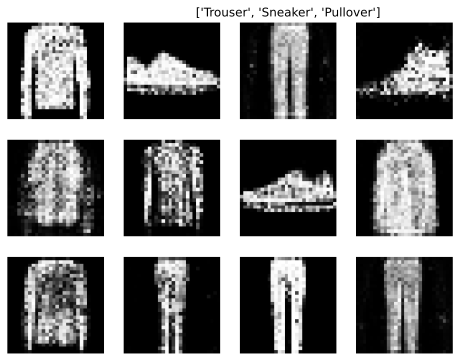

In [35]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')
axs[0, 2].set_title(str(set_1))
plt.show()

### Do for set 2

In [37]:
epochs = 50_000
descriminatory_descisions = np.zeros((epochs, 2))
losses = np.zeros((epochs, 2))

for ei in range(epochs):

    # Train the descriminator
    x_real, y_real = next(iter(train_loader_4))
    x_real = x_real.to(device=device)
    y_real = y_real.to(device=device)
    y_pred_real = dnet(x_real)
    d_loss_real =  d_lossfunc(y_pred_real, y_real)

    x_fake = gnet(torch.randn(batch_size, 64, device=device))
    y_fake = torch.zeros(batch_size, 1, device=device)
    y_fake_pred = dnet(x_fake)
    d_loss_fake = d_lossfunc(y_fake_pred, y_fake)

    d_loss = d_loss_real + d_loss_fake

    losses[ei, 0] = d_loss.cpu().item()
    descriminatory_descisions[ei, 0] = torch.mean((y_pred_real>.5).float()).cpu().item()

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # Train the Generator
    x_fake = gnet(torch.randn(batch_size, 64, device=device))
    y_fake = torch.ones(batch_size, 1, device=device) # as these are to be considered as true desired tensors
    y_pred_fake = dnet(x_fake)
    g_loss = g_lossfunc(y_pred_fake, y_fake)

    losses[ei, 1] = g_loss.cpu().item()
    descriminatory_descisions[ei, 1] = torch.mean((y_pred_fake>.5).float()).cpu().item()

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if (ei+1)%500==0:
        print(f"Epoch {ei+1}: d_loss {losses[ei, 0]:.2f}, g_loss {losses[ei, 1]:.2f}, desc acc {descriminatory_descisions[ei, 0]:.2f}, gen acc {descriminatory_descisions[ei, 1]:.2f}")


Epoch 500: d_loss 0.40, g_loss 2.07, desc acc 0.91, gen acc 0.16
Epoch 1000: d_loss 0.82, g_loss 1.35, desc acc 0.97, gen acc 0.19
Epoch 1500: d_loss 0.68, g_loss 1.27, desc acc 0.88, gen acc 0.22
Epoch 2000: d_loss 1.46, g_loss 1.36, desc acc 0.59, gen acc 0.22
Epoch 2500: d_loss 1.20, g_loss 1.06, desc acc 0.72, gen acc 0.25
Epoch 3000: d_loss 1.11, g_loss 1.13, desc acc 0.66, gen acc 0.31
Epoch 3500: d_loss 1.47, g_loss 0.76, desc acc 0.84, gen acc 0.59
Epoch 4000: d_loss 1.02, g_loss 1.48, desc acc 0.62, gen acc 0.16
Epoch 4500: d_loss 1.03, g_loss 1.39, desc acc 0.59, gen acc 0.06
Epoch 5000: d_loss 1.26, g_loss 0.82, desc acc 0.53, gen acc 0.31
Epoch 5500: d_loss 1.40, g_loss 1.21, desc acc 0.47, gen acc 0.34
Epoch 6000: d_loss 1.58, g_loss 0.99, desc acc 0.56, gen acc 0.44
Epoch 6500: d_loss 0.96, g_loss 1.33, desc acc 0.66, gen acc 0.16
Epoch 7000: d_loss 1.28, g_loss 2.26, desc acc 0.44, gen acc 0.06
Epoch 7500: d_loss 1.33, g_loss 1.15, desc acc 0.56, gen acc 0.25
Epoch 8000:

In [38]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(descriminatory_descisions)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

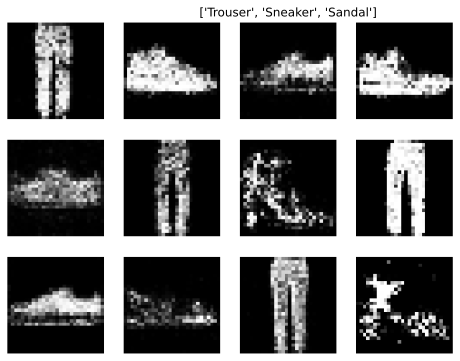

In [40]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')
axs[0, 2].set_title(str(set_2))
plt.show()